# Decision Trees

In [1]:
%matplotlib inline
import numpy as np

from sklearn import datasets as ds
from sklearn.decomposition import PCA
from sklearn import preprocessing

import matplotlib.pyplot as plt

## Import data

In [2]:
data_all = ds.load_breast_cancer()

x = data_all.data
y = data_all.target

y_names = data_all.target_names 

feature_names = data_all.feature_names

## Breast Cancer Wisconsin (Diagnostic) Database
A description of the dataset used is provided here.

Data Set Characteristics:
    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, field
        13 is Radius SE, field 23 is Worst Radius.

        - target class:
                - WDBC-Malignant
                - WDBC-Benign

    :Summary Statistics:

    ===================================== ====== ======
                                           Min    Max
    ===================================== ====== ======
    radius (mean):                        6.981  28.11
    texture (mean):                       9.71   39.28
    perimeter (mean):                     43.79  188.5
    area (mean):                          143.5  2501.0
    smoothness (mean):                    0.053  0.163
    compactness (mean):                   0.019  0.345
    concavity (mean):                     0.0    0.427
    concave points (mean):                0.0    0.201
    symmetry (mean):                      0.106  0.304
    fractal dimension (mean):             0.05   0.097
    radius (standard error):              0.112  2.873
    texture (standard error):             0.36   4.885
    perimeter (standard error):           0.757  21.98
    area (standard error):                6.802  542.2
    smoothness (standard error):          0.002  0.031
    compactness (standard error):         0.002  0.135
    concavity (standard error):           0.0    0.396
    concave points (standard error):      0.0    0.053
    symmetry (standard error):            0.008  0.079
    fractal dimension (standard error):   0.001  0.03
    radius (worst):                       7.93   36.04
    texture (worst):                      12.02  49.54
    perimeter (worst):                    50.41  251.2
    area (worst):                         185.2  4254.0
    smoothness (worst):                   0.071  0.223
    compactness (worst):                  0.027  1.058
    concavity (worst):                    0.0    1.252
    concave points (worst):               0.0    0.291
    symmetry (worst):                     0.156  0.664
    fractal dimension (worst):            0.055  0.208
    ===================================== ====== ======

    :Missing Attribute Values: None

    :Class Distribution: 212 - Malignant, 357 - Benign

    :Creator:  Dr. William H. Wolberg, W. Nick Street, Olvi L. Mangasarian

    :Donor: Nick Street

    :Date: November, 1995

This is a copy of the UCI ML Breast Cancer Wisconsin (Diagnostic) dataset from https://goo.gl/U2Uwz2

## 1. Prepare/Split data

In [3]:
split = int(x.shape[0] * 0.6)

x_train = x[:split,:]
y_train = y[:split]

x_test = x[split:,:]
y_test = y[split:]

print('Training set size:', x_train.shape[0])
print('Test set size:', x_test.shape[0])

Training set size: 341
Test set size: 228


## 2. Dimensionality Reduction with PCA

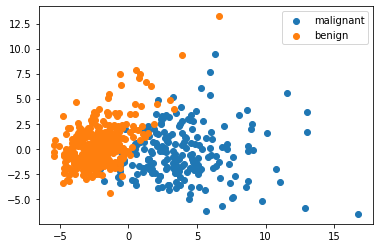

In [4]:
pca = PCA(n_components=2)
x_scaled = preprocessing.scale(x[:,:-1]) # We remove the indexing and make sure all the features are in N(0,1)
x_reduced = pca.fit_transform(x_scaled)
#x_reduced = pca.fit_transform(x[:,0:-1]) # Uncomment this to see the result without scaling


# **************************************************************** 1 mark

#create malignant datasets
malignant_index = np.where(y==0)
malignant_index = malignant_index[0]

malignant_x_reduced = np.array(x_reduced)[malignant_index]
malignant_x_reduced_pc1 = malignant_x_reduced[:,0]
malignant_x_reduced_pc2 = malignant_x_reduced[:,-1]

#create benign datasets
benign_index = np.where(y==1)
benign_index = benign_index[0]

benign_x_reduced = np.array(x_reduced)[benign_index]
benign_x_reduced_pc1 = benign_x_reduced[:,0]
benign_x_reduced_pc2 = benign_x_reduced[:,-1]


plt.scatter(malignant_x_reduced_pc1, malignant_x_reduced_pc2)
plt.scatter(benign_x_reduced_pc1, benign_x_reduced_pc2)
plt.legend(['malignant', 'benign'])

## 3. Building the Decision Tree

In [5]:
import math

def calculate_entropy(y):
    
    # **************************************************************** 4 marks
    #print("calculating entropy...")
    n = 0
    
    # count number of unique values of y in all classes
    for i in np.unique(y):
        try:
            n += (np.unique(y, return_counts=True)[1][i])
        except:
            n = (np.unique(y, return_counts=True)[1][0])
            if n.size == 0:
                entropy = 0
                return entropy
            
    entropy = 0
    #print("# unique y values is: ", n)
    
    # calculate entropy
    for i in np.unique(y):
        try:
            class_n = np.unique(y,return_counts = True)[1][i]
        except:
            entropy = 0
            return entropy
        
        #print("class: " + str(i) + " count: " + str(class_n))
        class_p = class_n/n
        #print("class: " + str(i) + " probability: " + str(class_p))
        entropy += -class_p*math.log2(class_p)
        #print("class: " + str(i) + " entropy: " +str(-class_p*math.log2(class_p)))
        
    #print("entropy: ", entropy)
      
    return entropy

print("The entropy of 'y' is: {:.4f}".format(calculate_entropy(y)))

The entropy of 'y' is: 0.9526


In [6]:
def find_split(x, y):
    """Given a dataset and its target values, this finds the optimal combination
    of feature and split point that gives the maximum information gain."""
    
    # Need the starting entropy so we can measure improvement...
    start_entropy = calculate_entropy(y)
    #print("start_entropy: ", start_entropy)
    # Best thus far, initialised to a dud that will be replaced immediately...
    best = {'infogain' : -np.inf}
    
    # Loop every possible split of every dimension...
    #print("finding split...")
    for i in range(x.shape[1]):
        for split in np.unique(x[:,i]):
            
            # **************************************************************** 5 marks
            #print("attribute: ", feature_names[i], " split: ", split)
            attr_list = x[:,i]
            #print("dimension: ", attr_list.ndim)
            left_indices = np.where(attr_list <= split)
            
            # left node
            '''
            if len(left_indices) > 1:
                left_indices = np.asarray(left_indices).ravel()
            '''
            #print("left: ")
            #print("indices: ", left_indices)
            
            try: 
                left_entropy = calculate_entropy(y[left_indices])
            except:
                left_entropy = calculate_entropy(y[left_indices[0]])
                
            left_count = len(y[left_indices])
            #print("count: ", left_count)
            #print(y[left_indices])
            #print("entropy: ", left_entropy)
            
            #right node
            #print("right: ")
            right_indices = np.where(attr_list > split)
            
            #print("indices: ", right_indices)
            '''
            if len(right_indices) > 1:
                right_indices = np.asarray(right_indices).ravel()
            '''
            try:
                right_entropy = calculate_entropy(y[right_indices])
            except:
                right_entropy = calculate_entropy(y[right_indices[0]])
                
            right_count = len(y[right_indices])
            
            #print("count: ", right_count)
            #print(y[right_indices])
            #print("entropy: ", right_entropy)
            
            # calculate information gain
            total_count = left_count + right_count
            #print("total count: ", total_count)
            infogain = start_entropy - ((left_count/total_count)*left_entropy + (right_count/total_count)*right_entropy)
            #print("info gain: ", infogain)
            
            # if infogain is best
            if infogain > best['infogain']:
                #print("found better infogain")
                #print("best left_indices: ", left_indices)
                #print("best right_indicesL ", right_indices)
                best = {'feature' : i,
                        'split' : split,
                        'infogain' : infogain, 
                        'left_indices' : left_indices[0],
                        'right_indices' : right_indices[0]}
    return best

#print('best: ', find_split(x,y))

In [7]:
def build_tree(x, y, max_depth = np.inf):
    # Check if either of the stopping conditions have been reached. If so generate a leaf node...
    if max_depth==1 or (y==y[0]).all():
        # Generate a leaf node...
        classes, counts = np.unique(y, return_counts=True)
        return {'leaf' : True, 'class' : classes[np.argmax(counts)]}
    
    else:
        move = find_split(x, y)
        
        left = build_tree(x[move['left_indices'],:], y[move['left_indices']], max_depth - 1)
        right = build_tree(x[move['right_indices'],:], y[move['right_indices']], max_depth - 1)
        
        return {'leaf' : False,
                'feature' : move['feature'],
                'split' : move['split'],
                'infogain' : move['infogain'],
                'left' : left,
                'right' : right}

## Model Evaluation

In [8]:
def predict(tree, samples):
    """Predicts class for every entry of a data matrix."""
    ret = np.empty(samples.shape[0], dtype=int)
    ret.fill(-1)
    indices = np.arange(samples.shape[0])
    
    def tranverse(node, indices):
        nonlocal samples
        nonlocal ret
        
        if node['leaf']:
            ret[indices] = node['class']
        
        else:
            going_left = samples[indices, node['feature']] <= node['split']
            left_indices = indices[going_left]
            right_indices = indices[np.logical_not(going_left)]
            
            if left_indices.shape[0] > 0:
                tranverse(node['left'], left_indices)
                
            if right_indices.shape[0] > 0:
                tranverse(node['right'], right_indices)
    
    tranverse(tree, indices)
    return ret

In [9]:
def cal_acc(pred, actual):
    
    correct = 0
    
    for i in range(len(pred)):
        if pred[i] == actual[i]:
            correct += 1
    
    acc = correct/len(pred)
    
    return acc


def evaluate(x_train, y_train, x_test, y_test, max_depth):
    
    # **************************************************************** 2 marks
    
    # build tree
    train_tree = build_tree(x_train, y_train, max_depth)
    
    # use tree to predict train set
    train_pred = predict(train_tree, x_train)
    
    # calculate train set accuracy
    train_acc = cal_acc(train_pred, y_train)
    
    # use tree to predict test set
    test_pred = predict(train_tree, x_test)
    
    # calculate test set accuracy
    test_acc = cal_acc(test_pred, y_test)
    
    return train_acc, test_acc


train_acc, test_acc = evaluate(x_train, y_train, x_test, y_test, np.inf)
print('Train Accuracy: {:.2f}%'.format(train_acc*100))
print('Test Accuracy: {:.2f}%'.format(test_acc*100))

Train Accuracy: 100.00%
Test Accuracy: 89.91%


## 5. Optimisation - Optimal Tree Depth

In [10]:
def find_best_max_depth(x_train, y_train, x_test, y_test):
    
    # **************************************************************** 2 marks
    
    best_max_depth = 0
    best_train_acc = 0
    best_test_acc = 0
    
    for i in range(2,6):
        
        train_acc, test_acc = evaluate (x_train, y_train, x_test, y_test, i)
        
        if test_acc > best_test_acc:
            best_max_depth = i
            best_train_acc = train_acc
            best_test_acc = test_acc
    
    return best_max_depth, best_train_acc, best_test_acc


best_max_depth, best_train_acc, best_test_acc = find_best_max_depth(x_train, y_train, x_test, y_test)
print('The best max_depth is {}, and the corresponding training and test accuracies are {:.2f}% and {:.2f}% respectively.'.format(best_max_depth,best_train_acc*100,best_test_acc*100))

The best max_depth is 4, and the corresponding training and test accuracies are 97.36% and 91.67% respectively.


## 6. Visualising the Final Decision Tree

In [11]:
def print_tree(tree, indent = 0):
    
    # **************************************************************** 1 mark
    
    if tree['leaf'] == False:
        
        # print left nodes
        print ('\t' * indent, "[x", str(tree['feature']).strip(), '<=', str(tree['split']).strip(), ']')
        print_tree(tree['left'], indent + 1)
            
        # print right nodes
        print ('\t' * indent, "[x", str(tree['feature']).strip(), '>', str(tree['split']).strip(), ']')
        print_tree(tree['right'], indent + 1)
        
    else:
        print('\t' * indent, "predict ", tree['class'])
    
    return 
    


tree = build_tree(x_train, y_train, best_max_depth)
print_tree(tree)

 [x 22 <= 105.0 ]
	 [x 24 <= 0.1733 ]
		 [x 21 <= 23.31 ]
			 predict  1
		 [x 21 > 23.31 ]
			 predict  1
	 [x 24 > 0.1733 ]
		 predict  0
 [x 22 > 105.0 ]
	 [x 22 <= 114.3 ]
		 [x 1 <= 19.65 ]
			 predict  1
		 [x 1 > 19.65 ]
			 predict  0
	 [x 22 > 114.3 ]
		 [x 7 <= 0.02771 ]
			 predict  1
		 [x 7 > 0.02771 ]
			 predict  0
